In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector
import tensorflow as tf
import os
from keras.layers import TimeDistributed
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
"""
New Data
"""
#data = pd.read_csv("curvy_data.csv")
data = pd.read_csv("traj_data_v2.csv")
data.describe()

,Unnamed: 0,Vehicle_ID,X,Y,X_REL,Y_REL
count,307834.00000,307834.000000,307834.000000,307834.000000,3.078340e+05,3.078340e+05
mean,153916.50000,153892.000884,151.187971,-33.894347,4.361413e-07,4.547582e-07
std,88864.16572,88864.166079,0.002386,0.001482,2.208221e-05,1.067770e-05
min,0.00000,0.000000,151.184833,-33.895620,-6.331820e-05,-4.471060e-05
25%,76958.25000,76950.000000,151.186520,-33.895157,-1.109110e-05,-5.980100e-06
50%,153916.50000,153900.000000,151.187506,-33.894778,0.000000e+00,0.000000e+00
75%,230874.75000,230850.000000,151.188627,-33.894293,1.225900e-05,7.062200e-06
max,307833.00000,307800.000000,151.194606,-33.888825,6.605090e-05,4.435870e-05


In [4]:
len(data['Vehicle_ID'].unique())

6157

In [5]:
"""
Preprocess data, removed torch tensors return type, now np arrays
"""
def preprocess_dataset(data, max = 10, max_len = 40, input_len = 30):
    scaler = MinMaxScaler(feature_range=(0, max))
    data[['X_REL', 'Y_REL']] = scaler.fit_transform(data[['X_REL', 'Y_REL']])
    global map_dict
    map_dict = {}
    unique_peds = data['Vehicle_ID'].unique()
    unique_peds = sorted(unique_peds)
    inputs = []
    indexes = []
    outputs = []
    seq = []
    for ped in unique_peds:
        if (len(data[data['Vehicle_ID'] == ped]) >= max_len):
          indexes.append(ped)
          seq_inner = []
          target_inner = 0
          i = 0
          for indx, row in data[data['Vehicle_ID'] == ped].iterrows():
            x = round(row['X_REL'])
            y = round(row['Y_REL'])
            ## Cantor pairing function:
            bin = y * max + x
            #print("X: ", x, " Y: ", y, " Bin: ", bin)
            map_dict[int(bin)] = [int(x), int(y)]
            i += 1
            if i == max_len:
              break
            seq_inner.append(int(bin))
          inputs.append([seq_inner[0:input_len]])
          outputs.append([seq_inner[input_len + 1:]])
    train_inputs, test_inputs, train_targets, test_targets, train_indx, test_indx = train_test_split(inputs, outputs, indexes, train_size=0.7, random_state=0)
    
    return np.array(train_inputs), np.array(test_inputs), np.array(train_targets), np.array(test_targets), train_indx, test_indx

In [6]:
train_data_inputs, test_data_inputs, train_data_targets, test_data_targets, train_indx, test_indx = preprocess_dataset(data, max = 100, max_len = 50, input_len = 20)

In [7]:
print(train_data_inputs.shape)
print(train_data_targets.shape)
train_data_inputs = train_data_inputs.reshape(train_data_inputs.shape[0], train_data_inputs.shape[2], 1)
train_data_targets = train_data_targets.reshape(train_data_targets.shape[0], train_data_targets.shape[2], 1)
print(train_data_inputs.shape)
print(train_data_targets.shape)

(4309, 1, 20)
(4309, 1, 28)
(4309, 20, 1)
(4309, 28, 1)


In [8]:
print(test_data_inputs.shape)
print(test_data_targets.shape)
test_data_inputs = test_data_inputs.reshape(test_data_inputs.shape[0], test_data_inputs.shape[2], 1)
test_data_targets = test_data_targets.reshape(test_data_targets.shape[0], test_data_targets.shape[2], 1)
print(test_data_inputs.shape)
print(test_data_targets.shape)

(1847, 1, 20)
(1847, 1, 28)
(1847, 20, 1)
(1847, 28, 1)


In [9]:
"""
def plot_prediction(test_index = 0, scaled = False):
  m = my_max
  i = inputs_scaled
  o = outputs_scaled
  if scaled == False:
    m = 1
    i = inputs
    o = outputs
  print(m)
  test_ind = test_index
  t = i[test_ind]
  t = t.reshape(1, 12, 2)
  b = model.predict(t)
  b = np.squeeze(b)
  xx = b[:,0] * m
  yy = b[:,1] * m
  check_tar = o[test_ind] * m
  check_input = i[test_ind] * m
  plt.plot(xx, yy, 'ro')
  plt.plot(check_tar[:,0], check_tar[:,1], 'bo')
  plt.plot(check_input[:,0], check_input[:,1])
"""

"\ndef plot_prediction(test_index = 0, scaled = False):\n  m = my_max\n  i = inputs_scaled\n  o = outputs_scaled\n  if scaled == False:\n    m = 1\n    i = inputs\n    o = outputs\n  print(m)\n  test_ind = test_index\n  t = i[test_ind]\n  t = t.reshape(1, 12, 2)\n  b = model.predict(t)\n  b = np.squeeze(b)\n  xx = b[:,0] * m\n  yy = b[:,1] * m\n  check_tar = o[test_ind] * m\n  check_input = i[test_ind] * m\n  plt.plot(xx, yy, 'ro')\n  plt.plot(check_tar[:,0], check_tar[:,1], 'bo')\n  plt.plot(check_input[:,0], check_input[:,1])\n"

In [10]:
def make_one_hot(inp):
  result = []
  for i in inp:
    inner = []
    for bin in i:
      one_hot_vector = np.zeros(((100*100) + 50), dtype= np.uint16)
      one_hot_vector[bin] = 1
      inner.append(one_hot_vector)
    result.append(inner)
  return np.array(result)

In [11]:
ti = make_one_hot(train_data_inputs)
tt = make_one_hot(train_data_targets)
val_in = make_one_hot(test_data_inputs) 
val_tar = make_one_hot(test_data_targets)

In [12]:
print(ti.nbytes)
print(tt.nbytes)
print(val_in.nbytes)
print(val_tar.nbytes)

1732218000
2425105200
742494000
1039491600


In [13]:
print(ti.shape)
print(tt.shape)
n = 1
while(n < 4924):
  if(4924 % n == 0):
    print(n)
  n += 1

(4309, 20, 10050)
(4309, 28, 10050)
1
2
4
1231
2462


In [14]:
print(val_in.shape, val_tar.shape)

(1847, 20, 10050) (1847, 28, 10050)


In [15]:
#fixing for batch size 4...
val_in = val_in[:-3]
val_tar = val_tar[:-3]

In [16]:
print(val_in.shape, val_tar.shape)

(1844, 20, 10050) (1844, 28, 10050)


In [17]:
n = 1
while(n < 1844):
  if(1844 % n == 0):
    print(n)
  n += 1

1
2
4
461
922


In [18]:
vocab_size = (100 * 100) + 50
input_len = 20
target_len = 28
train_inputs = ti
train_targets = tt
test_inputs = val_in
test_targets = val_tar

In [60]:
#here both inp and tar must be same length
"""
model = Sequential()
model.add(LSTM(50, batch_input_shape=(1, input_len, vocab_size), return_sequences=True, stateful=True))
model.add(LSTM(50, batch_input_shape=(1, target_len, vocab_size), return_sequences=True, stateful=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
"""

"\nmodel = Sequential()\nmodel.add(LSTM(50, batch_input_shape=(1, input_len, vocab_size), return_sequences=True, stateful=True))\nmodel.add(LSTM(50, batch_input_shape=(1, target_len, vocab_size), return_sequences=True, stateful=True))\nmodel.add(TimeDistributed(Dense(vocab_size, activation='softmax')))\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n"

In [146]:
#this model used
#https://machinelearningmastery.com/how-to-use-an-encoder-decoder-lstm-to-echo-sequences-of-random-integers/
model = Sequential()
model.add(LSTM(1000, batch_input_shape=(4, input_len, vocab_size), activation='tanh', stateful=False, dropout=0.1))
model.add(RepeatVector(target_len))
model.add(LSTM(750, return_sequences=True, activation='tanh', stateful=False, dropout=0.1))
model.add(LSTM(500, return_sequences=True, activation='tanh', stateful=False, dropout=0.1))
model.add(LSTM(500, return_sequences=True, activation='tanh', stateful=False, dropout=0.1))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [147]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (4, 1000)                 44204000  
_________________________________________________________________
repeat_vector_17 (RepeatVect (4, 28, 1000)             0         
_________________________________________________________________
lstm_53 (LSTM)               (4, 28, 750)              5253000   
_________________________________________________________________
lstm_54 (LSTM)               (4, 28, 500)              2502000   
_________________________________________________________________
lstm_55 (LSTM)               (4, 28, 500)              2002000   
_________________________________________________________________
time_distributed_17 (TimeDis (4, 28, 10050)            5035050   
Total params: 58,996,050
Trainable params: 58,996,050
Non-trainable params: 0
_________________________________________

In [142]:
model.save('new.h5')

In [87]:
restored_model = keras.models.load_model('sgdmodel.h5')

In [ ]:
history = model.fit(
    train_inputs,
    train_targets,
    batch_size=4,
    epochs=10,
    validation_data=(test_inputs, test_targets)
)

Epoch 1/10
1078/1078 [==============================] - 71s 66ms/step - loss: 6.8244 - accuracy: 0.0590 - val_loss: 6.5709 - val_accuracy: 0.0721
Epoch 2/10
1078/1078 [==============================] - 69s 64ms/step - loss: 6.3075 - accuracy: 0.0547 - val_loss: 6.2601 - val_accuracy: 0.0686
Epoch 3/10
 117/1078 [==>...........................] - ETA: 51s - loss: 6.3173 - accuracy: 0.0391

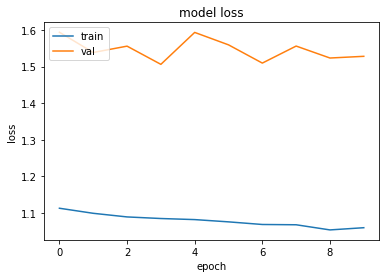

In [126]:
#plotting losses, https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
input_len = 20
target_len = 28
train_inputs = ti
train_targets =tt
test_inputs = val_in
test_targets = val_tar

In [127]:
def get_predictions(model, data_source_inputs, data_source_targets, batch_size=4):

    predictions = []
    ground_truths = []
    inputs = []

    #batch size 4 means we must predict in batches of 4 (keras/tf limitation)
    for i in range(0, data_source_inputs.shape[0], batch_size):
        res = model.predict(data_source_inputs[i:i+batch_size])
        #print("Predicted next four", i, i+4)
        for z in range(batch_size):
            for j in range(target_len):
                ground_truths.append(np.argmax(data_source_targets[z][j]))
                #res is (4,28,10050)
                predictions.append(np.argmax(res[z][j]))

            for k in range(input_len):
                inputs.append(np.argmax(data_source_inputs[z][k]))
            
    return inputs, ground_truths, predictions

In [133]:
inputs_list, target_list, preds_list = get_predictions(model, test_inputs, test_targets)



In [129]:
import math
def calculate_eucledian_mse(targets, preds):
  err = 0
  for indx in range(0, len(targets)):
    x_target = targets[indx] % 100
    y_target = targets[indx] / 100

    x_preds = preds[indx] % 100
    y_preds = preds[indx] / 100

    dist = math.hypot(x_target - x_preds, y_target - y_preds) 
    err += dist
  return (err / len(targets))

In [134]:
calculate_eucledian_mse(target_list, preds_list)

29.723235435829338

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import time

def vis_trajectory_scatter(lag_time = 1.0):
  #input_list, target_list, preds_list = get_predictions(best_model, data_src_inputs, data_src_targets)

    min_val, max_val = 0, 100

    # fig, ax = plt.subplots()
    plt.figure(figsize=(3,3))

    xy_inputs = []
    xy_preds = []
    xy_target = []

    for inp in inputs_list:
      x = inp % 100
      y = inp / 100 

      xy_inputs.append([x, y])

    for inp in preds_list:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in target_list:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    for num_of_plots in range(0,200,1):
        inp_index = 20 * num_of_plots
        pred_ind = 28 * num_of_plots
        
        plot_x_inp, plot_y_inp, plot_x_pred, plot_y_pred, plot_x_gt, plot_y_gt = [], [], [], [], [], []

        for i in range(inp_index - 20, inp_index, 1):
            plot_x_inp.append(x_inp[i])
            plot_y_inp.append(y_inp[i])
        for i in range(pred_ind - 28, pred_ind, 1):
            plot_x_pred.append(x_pred[i])
            plot_y_pred.append(y_pred[i])
            plot_x_gt.append(x_tar[i])
            plot_y_gt.append(y_tar[i])

        plt.scatter(plot_x_inp,plot_y_inp)
        plt.scatter(plot_x_gt,plot_y_gt, color='r')
        plt.scatter(plot_x_pred,plot_y_pred)

        plt.xlim(0, 100)
        plt.ylim(0, 100)

        plt.show()
        """
        print("Input: ", xy_inputs)
        print("Preds: ", xy_preds)
        print("Truth: ", xy_target)
        """
        time.sleep(lag_time)

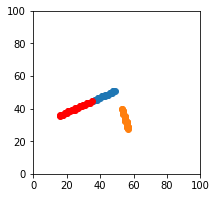

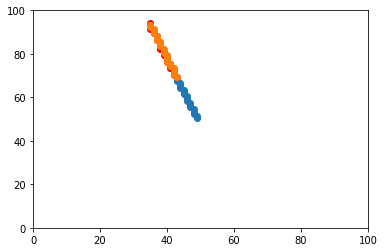

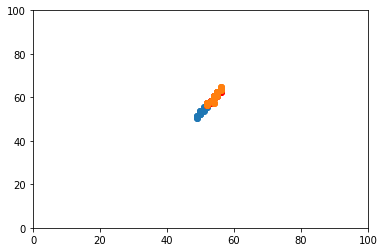

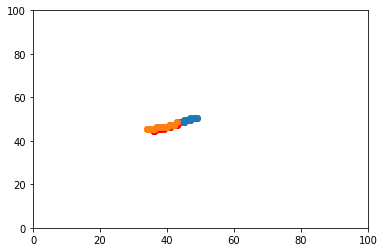

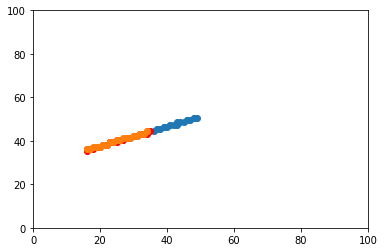

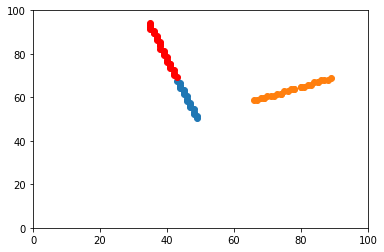

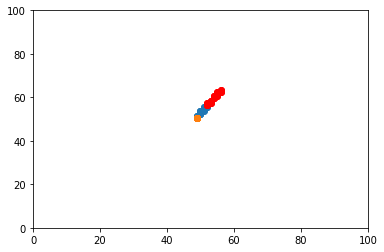

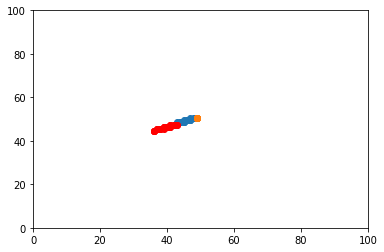

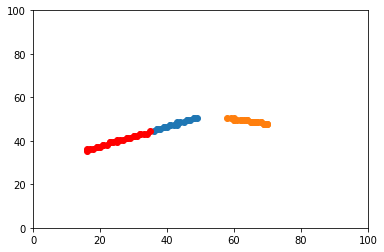

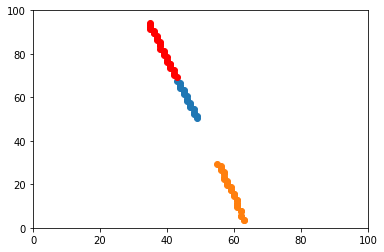

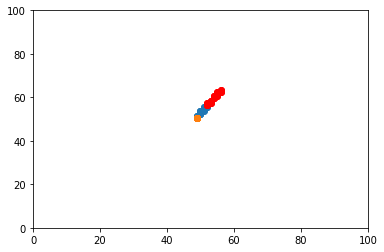

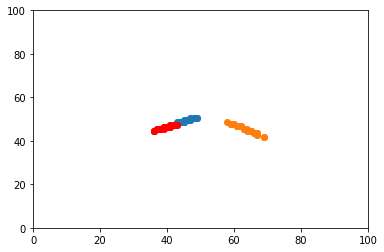

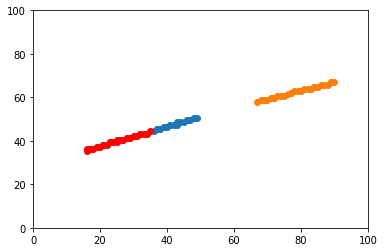

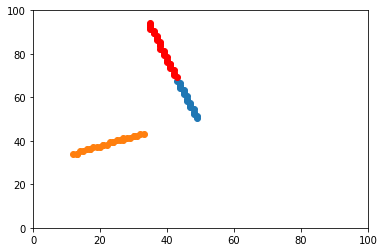

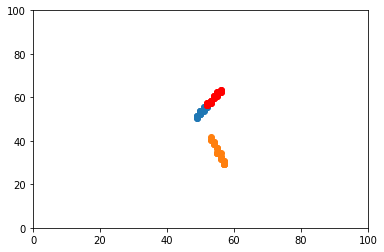

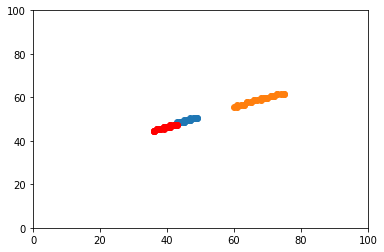

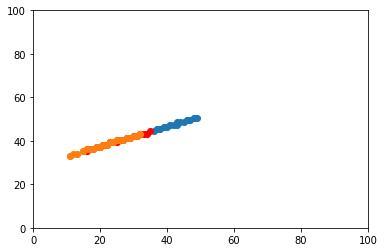

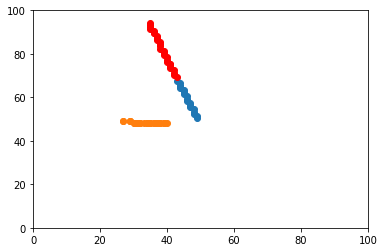

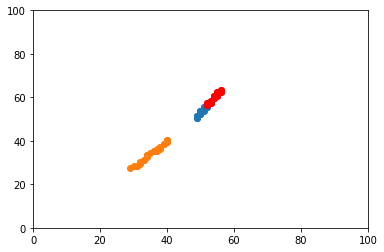

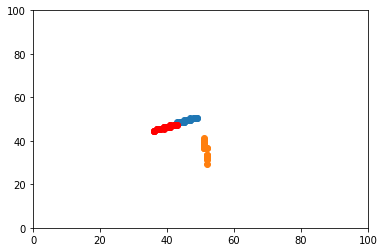

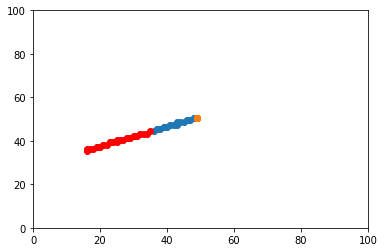

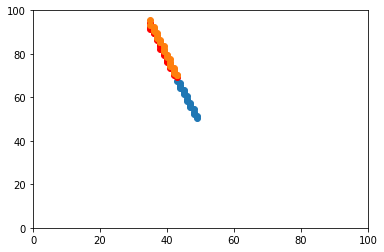

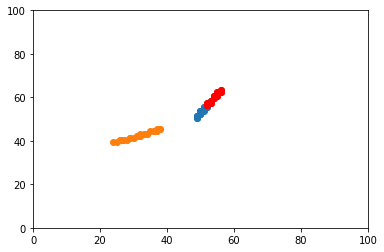

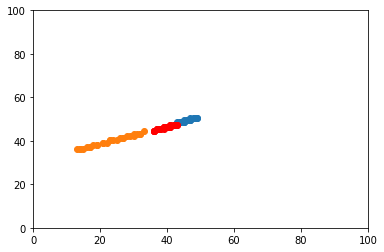

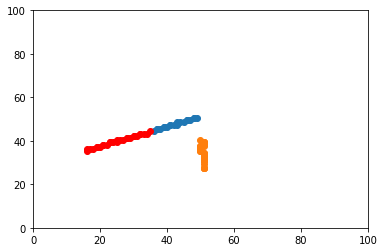

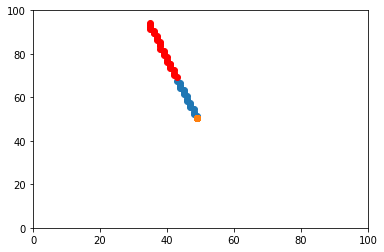

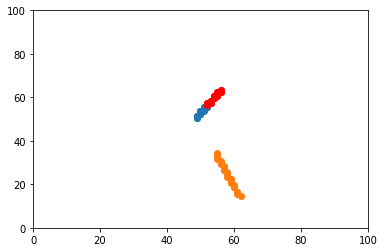

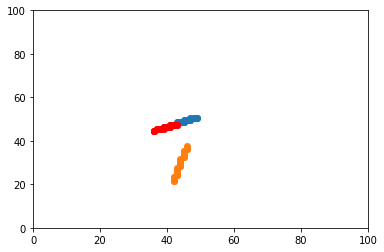

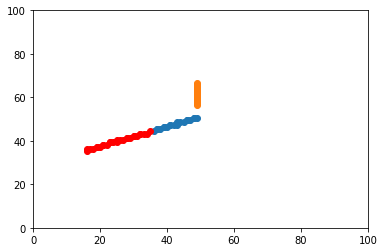

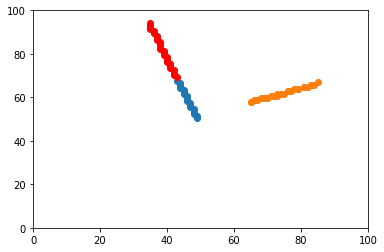

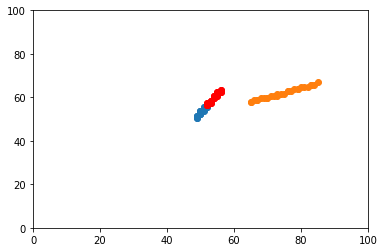

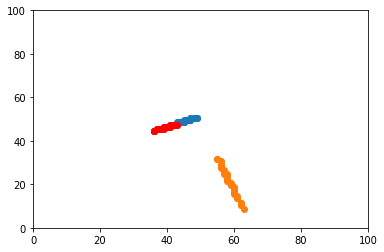

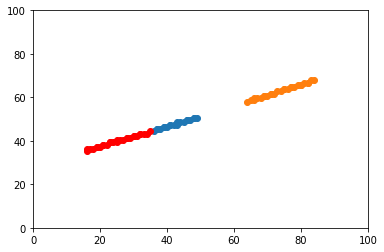

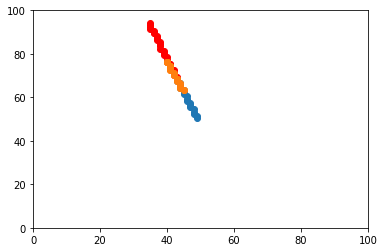

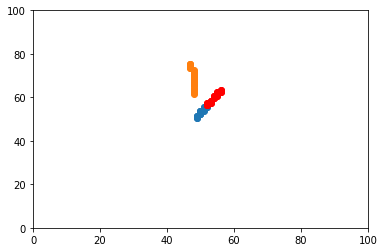

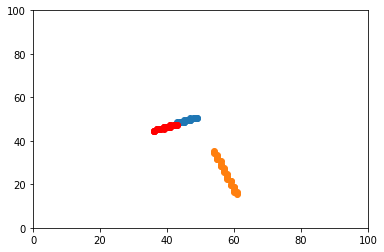

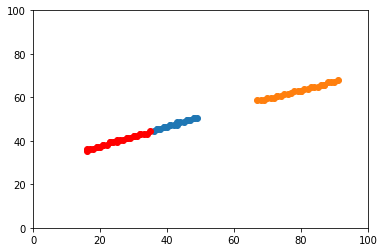

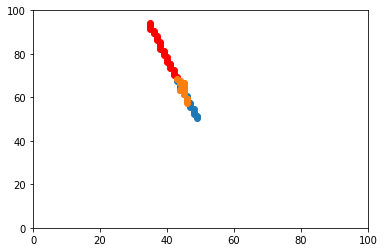

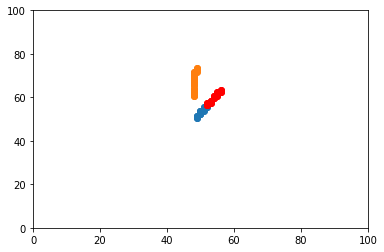

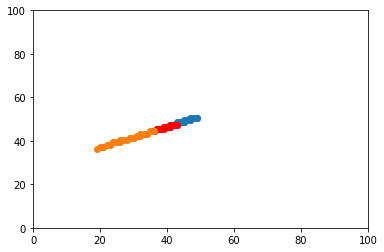

KeyboardInterrupt: 

In [136]:
vis_trajectory_scatter()

In [24]:
def get_coordinates():
  #input_list, target_list, preds_list = get_predictions(best_model, data_src_inputs, data_src_targets)

    min_val, max_val = 0, 100

    xy_inputs = []
    xy_preds = []
    xy_target = []

    for inp in inputs_list:
      x = inp % 100
      y = inp / 100 

      xy_inputs.append([x, y])

    for inp in preds_list:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in target_list:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)
    
    return xy_inputs, xy_preds, xy_target

In [32]:
xy_in, xy_preds, xy_tar = get_coordinates()

In [64]:
output_df[['X_REAL', 'Y_REAL']] = scaler.inverse_transform(output_df[['X_REAL', 'Y_REAL']])
output_df[['X_PRED', 'Y_PRED']] = scaler.inverse_transform(output_df[['X_PRED', 'Y_PRED']])

NameError: name 'scaler' is not defined

In [53]:
for inp in test_indx[0]:
    print(inp)

TypeError: 'numpy.int64' object is not iterable